In [ ]:
import pandas as pd
from streetlevel import lookaround
import pickle
from PIL import Image
from os import path

import sys
sys.path.append("../scripts")
from utils.image_processing import SidewalkBalletImage, draw_with_boxes
from utils.conversion import cube_to_panorama_pil_scipy, extract_perspective_view_scipy

df = pd.read_csv("../csv/group_detection_depth255_dist1.0_expansion_remove_unrealperson.csv")

### 0 Collect Street level images

This is not included in the scope of this papre, but it can be done through third-party packages, such as streetlevel package (https://streetlevel.readthedocs.io/en/master/index.html).

### 1 Merge the Image to a wider view

Let's say we have the pano view from apple look around, the id is: 13804649323994761822

In [87]:
pano_id = "13804649323994761822"

with open("../example/camera_metadata_13804649323994761822.pkl", "rb") as f:
    camera_metadata = pickle.load(f)
    
faces = []
for i in range(6):
    faces.append(Image.open(f"../example/13804649323994761822_{i}.jpg"))

# merge the image
result = lookaround.to_equirectangular(faces, camera_metadata)

### 2 Create the Side View

In [88]:
df[df["id"] == pano_id]

filename  image_id  group_id  cnt_people  cnt_group  \
9065  13804649323994761822_3.png   10519.0       0.0         5.0        2.0   
9066  13804649323994761822_3.png   10519.0       1.0         5.0        2.0   

                                    box_detected_person  \
9065  [[79, 434, 121, 532], [123, 443, 154, 530], [2...   
9066  [[79, 434, 121, 532], [123, 443, 154, 530], [2...   

                   group_box  \
9065     [79, 434, 154, 532]   
9066  [1131, 435, 1210, 555]   

                                      box_within_group  \
9065       [[79, 434, 121, 532], [123, 443, 154, 530]]   
9066  [[1131, 435, 1162, 542], [1169, 440, 1210, 555]]   

      cnt_person_within_group person_box_is_unreal_person has_unreal source  \
9065                      2.0                         NaN      False  apple   
9066                      2.0                         NaN      False  apple   

                        id  
9065  13804649323994761822  
9066  13804649323994761822

OK, we could see there are two rows in this pano, meaning that we have two groups detected!
And since we see the postfix of that image is 3, meaning it is the right view. (0-back, 1-left, 2-front, 3-right, 4-top, and 5-bottom)

In [61]:
right_side_view = extract_perspective_view_scipy(result, fov_h=150, fov_v=150, center_azimuth=90, out_w=1600, out_h=1600).crop((0, 400, 1600, 1200))

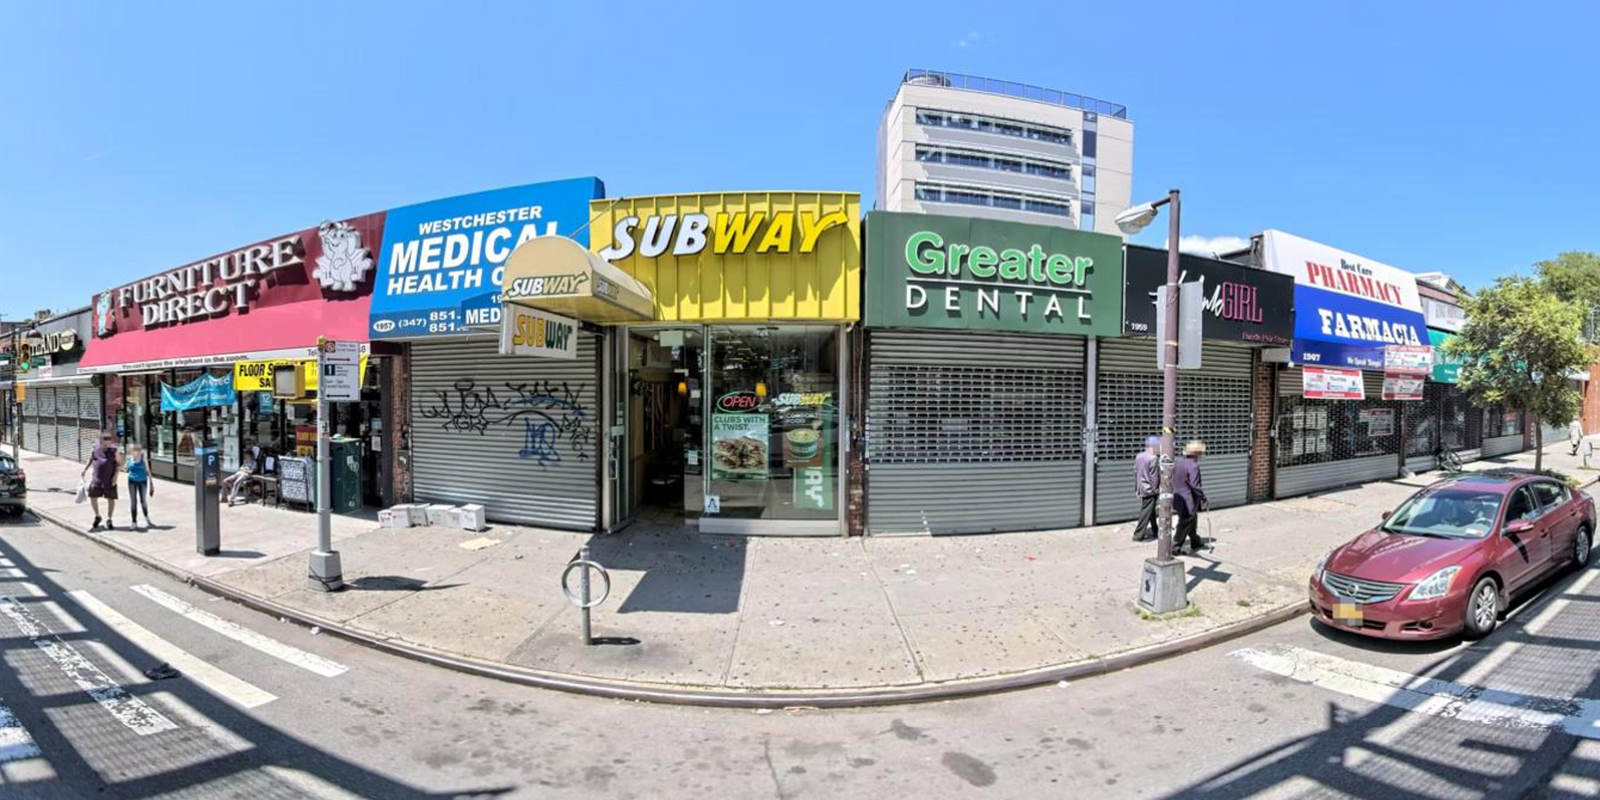

In [62]:
right_side_view

### 3 Check the detected Groups

In [91]:
box_group = df[df["id"] == pano_id]["group_box"].apply(eval).tolist()
box_detected_person = df[df["id"] == pano_id]["box_detected_person"].apply(eval).tolist()[0]
img = SidewalkBalletImage(right_side_view, box_detected_person)
image_final = draw_with_boxes(img.show(all_boxes = True), box_group, width = 5, color = "blue", labels=False, text_height = 10)     

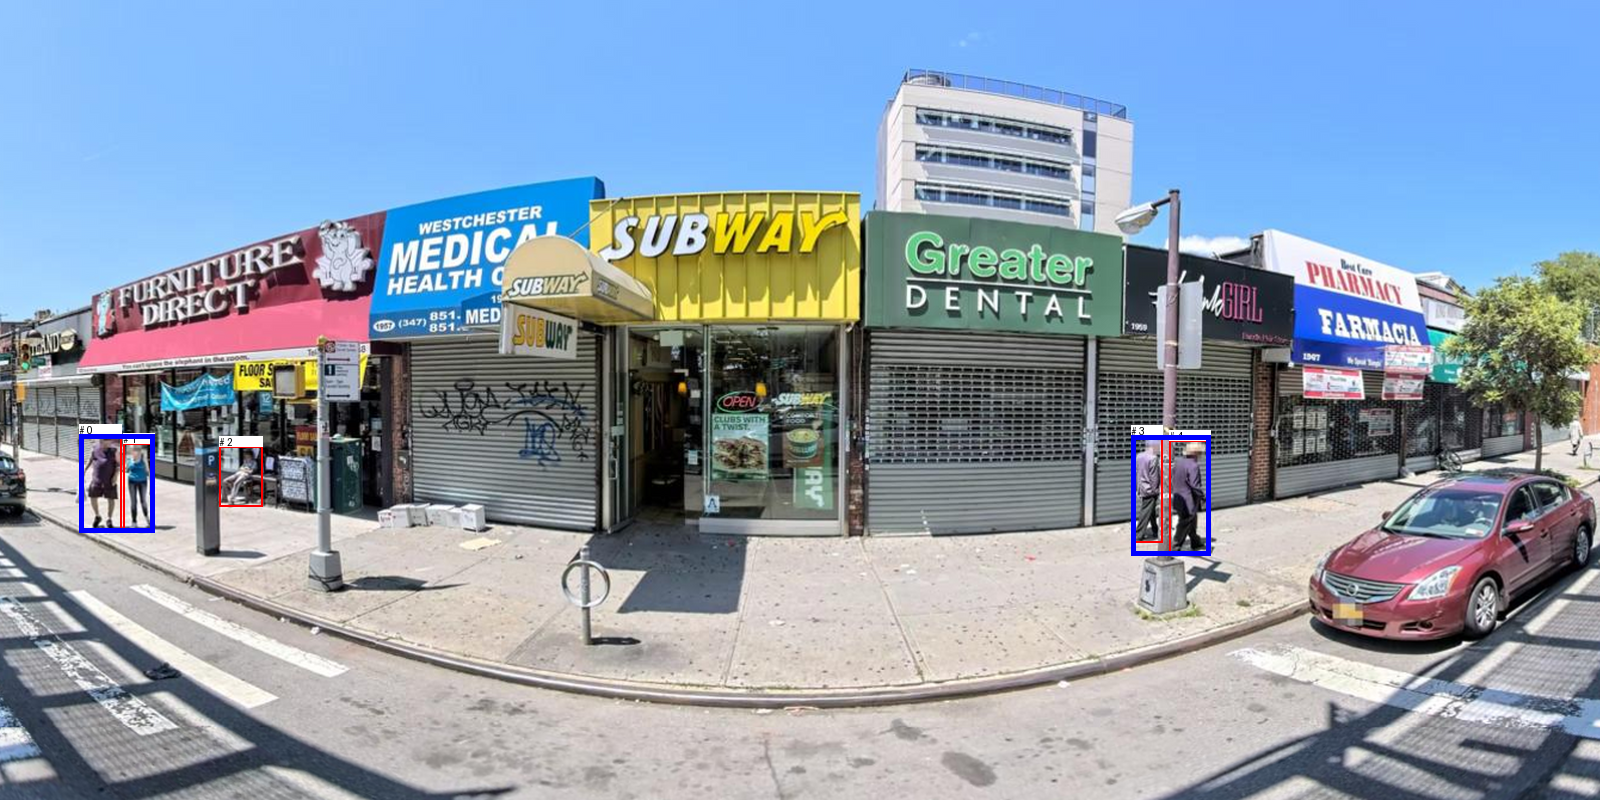

In [98]:
image_final

### 4 For other Data Source

For Bing and Google, please directly use cube_to_panorama_pil_scipy to substitute the step 1 (to_equirectangular)
other parts are the same.

For Mapillary, there's no need to create the panoramio photos.